In [2]:
import os

from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
from pandas.plotting import table
from ase.geometry.analysis import Analysis as asis
from ase.io import read, write
from ase.neighborlist import NeighborList as NL
from ase.neighborlist import natural_cutoffs
from matplotlib import pyplot as plt
from rascal.representations.spherical_invariants import (
    get_power_spectrum_index_mapping as get_map,
)
from rascal.representations import SphericalInvariants as SOAP
import dataframe_image as dfi

MEDIUM = 16
SMALL = 12
LARGE = 20
font_params = {
    "axes.labelsize": MEDIUM,
    "axes.titlesize": LARGE,
    "figure.titlesize": LARGE,
    "font.size": MEDIUM,
    "legend.fontsize": SMALL,
    "legend.title_fontsize": SMALL,
    "xtick.labelsize": SMALL,
    "ytick.labelsize": SMALL,
}
for key, val in font_params.items():
    plt.rcParams[key] = val

names = {"C": "Carbon", "H": "Hydrogen"}
colors = {"H": (0.6, 0.6, 0.6), "C": (0.2, 0.2, 0.2)}

hypers = dict(
    max_radial=100,
    interaction_cutoff=2.5,
    cutoff_smooth_width=0.1,
    max_angular=1,
    radial_basis="DVR",
    gaussian_sigma_type="Constant",
    gaussian_sigma_constant=0.3,
)

In [3]:
frame = read('../../cyclohexane_data/conformers/chair.xyz')
frame.wrap(eps=1E-10)

In [4]:
positions = frame.positions
positions -= positions.min(axis=0)
order = list(sorted(range(len(frame)), key=lambda i: (-frame.numbers[i], *positions[i])))

positions = np.round(positions, 3)[order].tolist()

In [6]:
nl = NL(
    cutoffs=np.multiply(1, natural_cutoffs(frame)),
    bothways=True,
    self_interaction=False,
)
nl.update(frame)
a = asis(frame, nl=nl)
angles = a.get_angles("C", "C", "C", unique=True)
angle_vals = a.get_values(angles)

bonds = a.get_bonds("C","C", unique=True)
bond_vals = a.get_values(bonds)

# positions
positions_table = pd.DataFrame(
    positions,
    index=[
        f"{frame.symbols[i]}{frame.numbers[:i].tolist().count(n)+1}"
        for i, n in enumerate(frame.numbers)
    ],
    columns=[r"$x$", r"$y$", r"$z$"],
)
dfi.export(positions_table,"positions.png", table_conversion='matplotlib')

positions_table

,$x$,$y$,$z$
C1,1.028,2.139,1.600
C2,1.745,3.390,1.090
C3,1.753,0.891,1.090
C4,3.188,3.394,1.600
C5,3.195,0.896,1.600
C6,3.913,2.147,1.090
H1,0.000,2.136,1.237
H2,1.028,2.139,2.690
H3,1.229,4.278,1.453
H4,1.241,0.000,1.453


In [15]:
# bond angles
bond_table = pd.DataFrame(
    np.transpose(np.round(angle_vals, 3)),
    index=["C{}-C{}-C{}".format(*np.sort(np.add(a, 1))) for a in angles[0]],
    columns=[r"Bond Angle ($^\circ$)"],
)
dfi.export(bond_table,"bonds.png", table_conversion='matplotlib')

bond_table

,Bond Angle ($^\circ$)
C1-C2-C3,109.466
C1-C2-C4,109.471
C1-C3-C6,109.470
C2-C4-C5,109.468
C4-C5-C6,109.470
C3-C5-C6,109.471


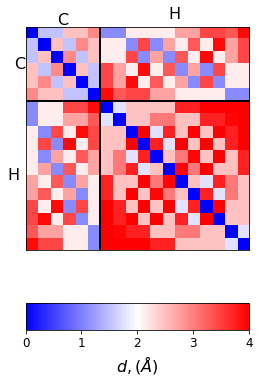

In [6]:
# Z-matrix
distances = np.array(
    [[np.linalg.norm(np.subtract(x, y)) for x in positions] for y in positions]
)

fig, (ax, cax) = plt.subplots(
    2, 1, figsize=(4,6), gridspec_kw=dict(height_ratios=(1.0, 0.1))
)
p = ax.imshow(distances, cmap="bwr", vmax=4.0)

ax.axvline(5.5, c="k", lw=2)
ax.axhline(5.5, c="k", lw=2)

ax.annotate("C", xy=(2.5, -0.5), xytext=(2.5, -1.0), ha="center", va="center")
ax.annotate("C", xy=(-0.5, 2.5), xytext=(-1.0, 2.5), ha="center", va="center")
ax.annotate("H", xy=(11.5, -0.5), xytext=(11.5, -1.5), ha="center", va="center")
ax.annotate("H", xy=(-0.5, 11.5), xytext=(-1.5, 11.5), ha="center", va="center")

ax.set_xticks([])
ax.set_yticks([])

plt.colorbar(
    p, label=r"$d, (\AA)$", ax=ax, cax=cax, orientation="horizontal", fraction=0.3
)
plt.savefig('Z_matrix.eps', pad_inches=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


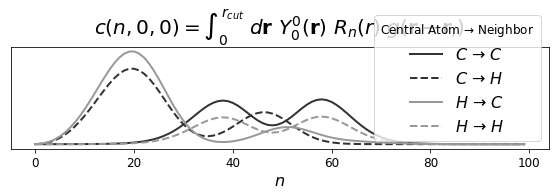

In [16]:
# Radial Spectrum (density coefficients)
soap = SOAP(soap_type="RadialSpectrum", **hypers)

radial_soap = soap.transform(frame).get_features(soap)

_, coeff_panel = plt.subplots(1, 1, figsize=(8, 3))
coeff_panel.plot(
    radial_soap[0, : radial_soap.shape[1] // 2].T,
    c=colors["C"],
    linestyle="solid",
    lw=2,
    label=r"$C\ \to\ C$",
)
coeff_panel.plot(
    radial_soap[0, radial_soap.shape[1] // 2 :].T,
    c=colors["C"],
    linestyle="dashed",
    lw=2,
    label=r"$C\ \to\ H$",
)

coeff_panel.plot(
    radial_soap[6, : radial_soap.shape[1] // 2].T,
    c=colors["H"],
    linestyle="solid",
    label=r"$H\ \to\ C$",
    lw=2,
)
coeff_panel.plot(
    radial_soap[6, radial_soap.shape[1] // 2 :].T,
    c=colors["H"],
    linestyle="dashed",
    label=r"$H\ \to\ H$",
    lw=2,
)

coeff_panel.set_title(
    r"$c\left(n, 0, 0\right) = \int_0^{r_{cut}}\ d\mathbf{r}\ Y_0^0(\mathbf{r})\ R_n(r)\ g\left(\mathbf{r} - \mathbf{r}_i\right)$"
)
coeff_panel.set_yticks([])
coeff_panel.set_xlabel(r"$n$")

coeff_panel.legend(
    title=r"Central Atom $\to$ Neighbor",
    fontsize=MEDIUM,
)
plt.tight_layout()
plt.savefig('cn00.eps', pad_inches=0)

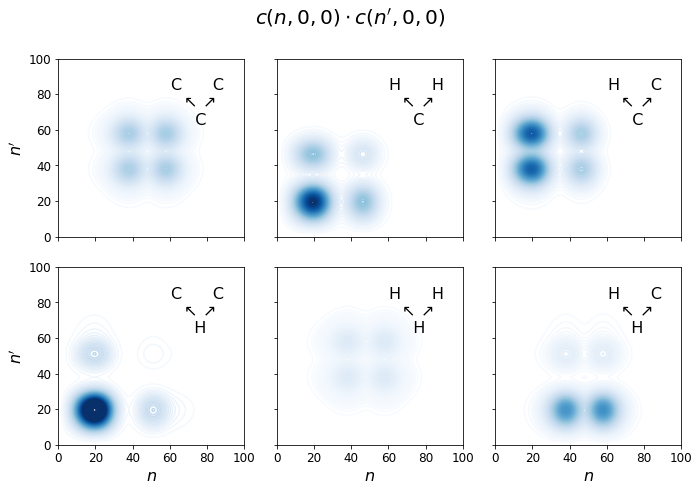

In [27]:
soap = SOAP(soap_type="PowerSpectrum", **hypers)
rep = soap.transform(frame)
feat = rep.get_features(soap)
mapping = np.array(
    [
        np.array(list(v.values()))
        for v in get_map(
            soap.get_keys((6, 1)),
            n_max=hypers["max_radial"],
            l_max=hypers["max_angular"] + 1,
        ).values()
    ]
)


symbols = {1: "H", 6: "C"}
l = 0
vmax = np.max(feat[0][np.where(mapping[:, -1] == l)[0]])

fig, soap_panel = plt.subplots(2,3 , figsize=(10, 7), sharex=True, sharey=True)
for axes, j in zip(soap_panel, [0, 6]):
    for ax, (a1, a2) in zip(axes, [[6, 6], [1, 1], [1,6]]):
        idx = np.where(
            ((mapping[:, 0] == a1) & (mapping[:, 1] == a2) & (mapping[:, -1] == l))
        )[0]

        n_mat = np.zeros((hypers["max_radial"], hypers["max_radial"]))
        for i in idx:
            m = mapping[i]
            n_mat[m[2], m[3]] = feat[j, i]

        names = [symbols[frame.numbers[j]], symbols[a1], symbols[a2]]

        ax.contour(
            n_mat,
            levels=100,
            cmap="Blues",
            vmin=0.0,
            vmax=vmax,
        )

        if j == 6:
            ax.set_xlabel(r"$n$")
#         else:
#             ax.set_xticklabels([])
#         if a1 + a2 != 12:
#             ax.set_yticklabels([])
        ax.text(
            x=75,
            y=75,
            s=names[1]
            + "      "
            + names[2]
            + "\n"
            + r"$\nwarrow"
            + " "
            + r"\nearrow$"
            + "\n  "
            + names[0]
            + " ",
            ha="center",
            va="center",
            fontsize=MEDIUM,
        )
        ax.set_xlim([0, 100])
        ax.set_ylim([0, 100])

        soap_panel[0, 0].set_ylabel(r"$n^\prime$")
soap_panel[1][0].set_ylabel(r"$n^\prime$")
fig.suptitle(
    r"$c\left(n, {}, {}\right) \cdot c\left(n^\prime, {}, {}\right)$".format(l, l, l, l)
)
fig.tight_layout()
plt.savefig('cn00.cn`00.eps', pad_inches=0)

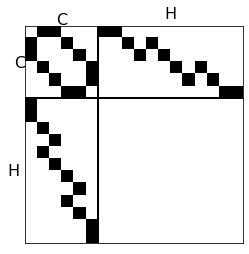

In [9]:
# adjacency-matrix
adjacency = np.array(
    [[np.linalg.norm(np.subtract(x, y)) for x in positions] for y in positions]
)
adjacency[adjacency==0] = np.inf

fig, ax = plt.subplots(
    1, 1, figsize=(4,4)
)
p = ax.imshow(adjacency<1.6, cmap="Greys", vmax=1.0)

ax.axvline(5.5, c="k", lw=2)
ax.axhline(5.5, c="k", lw=2)

ax.annotate("C", xy=(2.5, -0.5), xytext=(2.5, -1.0), ha="center", va="center")
ax.annotate("C", xy=(-0.5, 2.5), xytext=(-1.0, 2.5), ha="center", va="center")
ax.annotate("H", xy=(11.5, -0.5), xytext=(11.5, -1.5), ha="center", va="center")
ax.annotate("H", xy=(-0.5, 11.5), xytext=(-1.5, 11.5), ha="center", va="center")

ax.set_xticks([])
ax.set_yticks([])

plt.savefig('adjacency_matrix.eps', pad_inches=0)

In [11]:
! open .